In [1]:
import sys
sys.path.append('..')

In [2]:
from inxai import *
from sklearn.datasets import make_classification, make_moons, make_circles
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, MinMaxScaler
import shap
import lime

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [3]:
def minmaxdf(df, scale=[-1,1]):
    # Using MinMaxScaler
    min_max_scaler = MinMaxScaler(feature_range=scale)    
    # Stack everything into a single column to scale by the global min / max
    tmp = df.to_numpy().reshape(-1,1)
    scaled = min_max_scaler.fit_transform(tmp).reshape(len(df), df.shape[1])
    return scaled
    

# Create synthetic classification dataset

# Make moons

In [30]:
X,y = sklearn.datasets.make_moons(n_samples=200,  noise=0.08, random_state=0)#factor=0.5
#X,y = sklearn.datasets.make_circles(n_samples=200,  noise=0.08,factor=0.5)
Xdf = pd.DataFrame(X, columns=['0','1'])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['0','1']
X_test.columns = ['0','1']

<AxesSubplot:xlabel='0', ylabel='1'>

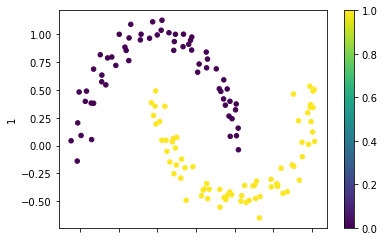

In [32]:
X_train.plot(kind='scatter',x='0', y='1',style='.', c=y_train, colormap='viridis')

In [33]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='rbf',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9848484848484849
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.96      0.98        28

    accuracy                           0.98        66
   macro avg       0.99      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



In [34]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb 
lr = xgb.XGBClassifier()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

[14:54:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [35]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.9696969696969697
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       1.00      0.93      0.96        28

    accuracy                           0.97        66
   macro avg       0.97      0.96      0.97        66
weighted avg       0.97      0.97      0.97        66



<AxesSubplot:xlabel='0', ylabel='1'>

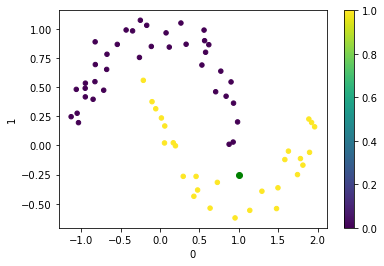

In [36]:
fig, ax = plt.subplots()
point = [1.0,-0.25]
ax.plot(point[0], point[1], 'og')
X_test.plot(kind='scatter',x='0', y='1', c=y_test, colormap='viridis', ax=ax)

In [37]:
X_test_appended = X_test.append(pd.DataFrame([point], columns=['0','1']), ignore_index=True)
y_test_appended = np.concatenate([y_test,[1]])

## Decision boundaries

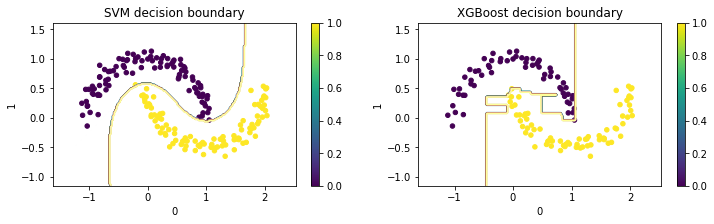

In [95]:
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = lr.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['0','1']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
Xdf.plot(kind='scatter',x='0', y='1',style='.', c=y, colormap='viridis',ax=ax[0])

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
X_train.plot(kind='scatter',x='0', y='1',style='.', c=y_train, colormap='viridis',ax=ax[1])
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')
fig.savefig('dataset.png')

### Stability

In [41]:
gm = GlobalFeatureMetric()

In [42]:
shap_res=generate_per_instance_importances(models=svc, X=X_test_appended, y=y_test_appended, framework='kernel_shap')
lime_res = generate_per_instance_importances(models=svc, X=X_test_appended, y=y_test_appended, framework='lime')

In [43]:
shap_res = minmaxdf(pd.DataFrame(shap_res), scale=[-1,1])
lime_res = minmaxdf(pd.DataFrame(lime_res), scale=[-1,1])

<AxesSubplot:xlabel='variable', ylabel='value'>

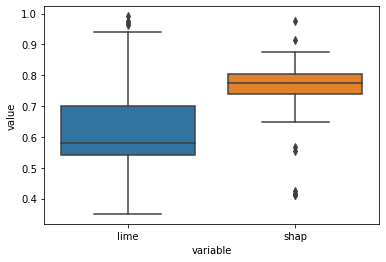

In [44]:
shape_lips = gm.stability(X_test_appended,shap_res ,epsilon=0.3)
lime_lips = gm.stability(X_test_appended,lime_res,epsilon=0.3 )

lip_df = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

### Consistency per model

In [45]:
res_lime_con = generate_per_instance_importances(models=[svc, lr], X=X_test_appended, y=y_test_appended, framework='lime') 
res_shap_con = generate_per_instance_importances(models=[svc, lr], X=X_test_appended, y=y_test_appended, framework='kernel_shap') 

In [46]:
res_lime_con = [minmaxdf(pd.DataFrame(rlc), scale=[-1,1]) for rlc in res_lime_con]
res_shap_con = [minmaxdf(pd.DataFrame(rsc), scale=[-1,1]) for rsc in res_shap_con]

<AxesSubplot:xlabel='variable', ylabel='value'>

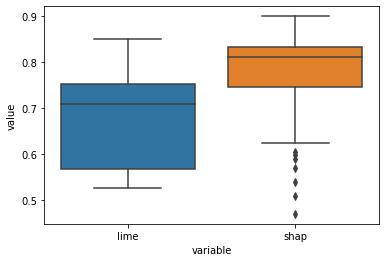

In [47]:
lime_cons = gm.consistency(res_lime_con)
shap_cons = gm.consistency(res_shap_con)
cons_df = pd.DataFrame({'lime':lime_cons, 'shap':shap_cons})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df))

### Per XAI consistency

In [48]:
res_lime_con_xai = generate_per_instance_importances(models=[svc], X=X_test_appended, y=y_test_appended, framework='lime') 
res_shap_con_xai = generate_per_instance_importances(models=[svc], X=X_test_appended, y=y_test_appended, framework='kernel_shap') 

In [49]:
res_lime_con_xai = minmaxdf(pd.DataFrame(res_lime_con_xai), scale=[-1,1])
res_lime_con_xai = minmaxdf(pd.DataFrame(res_lime_con_xai), scale=[-1,1])

<AxesSubplot:xlabel='variable', ylabel='value'>

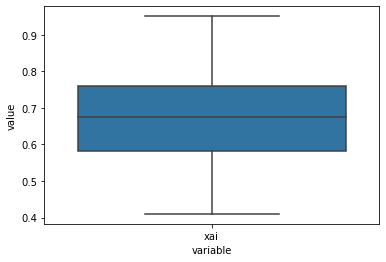

In [50]:
lime_shap_cons_xai = gm.consistency([res_lime_con_xai,res_shap_con_xai])
cons_df_xai = pd.DataFrame({'xai':lime_shap_cons_xai})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df_xai))

## Area under the ACCLOSS

In [51]:
import shap
import lime

In [52]:
explainer_shap = shap.KernelExplainer(svc.predict_proba, X_train)

Using 134 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [53]:
explainer_lime =lime.lime_tabular.LimeTabularExplainer(X_train,feature_names=list(X_train.columns), 
                                                       class_names=['0','1'], discretize_continuous=False)

In [54]:
shap_res_instance = explainer_shap.shap_values(X_test_appended)

In [55]:
explainer_lime.explain_instance(X_test.iloc[0],svc.predict_proba).as_list()

[('1', -0.33884426569320303), ('0', 0.12992444548908544)]

In [56]:
def expl(row):
    e = explainer_lime.explain_instance(row,svc.predict_proba).as_list()
    return [e[0][1],e[1][1]]

In [57]:
shap_res_global = pd.DataFrame(shap_res_instance[0]).apply(abs).mean()

In [58]:
lime_res_global = X_test.apply(lambda x: expl(x), axis=1, result_type='expand').apply(abs).mean()

In [59]:
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=2),X_test_appended.columns)])

In [60]:
acc_loss_shap = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=shap_res_global, 
                                        resolution=50,  count_per_step=10, plot=False)

In [61]:
acc_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=lime_res_global, 
                                        resolution=50,  count_per_step=10, plot=False)

In [62]:
auc_df = pd.DataFrame({'lime':[auc(np.linspace(0, 1, 50),acc_loss_lime)], 'shap':[auc(np.linspace(0, 1, 50),acc_loss_shap)]})

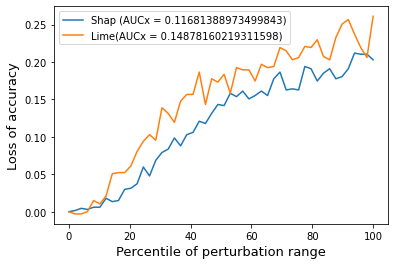

In [63]:
plt.plot(np.linspace(0, 100, 50), acc_loss_shap)
plt.plot(np.linspace(0, 100, 50), acc_loss_lime)
plt.xlabel('Percentile of perturbation range', fontsize=13)
plt.ylabel('Loss of accuracy', fontsize=13)
plt.legend(['Shap (AUCx = '+str(auc(np.linspace(0, 1, 50),acc_loss_shap))+')','Lime(AUCx = '+str(auc(np.linspace(0, 1, 50),acc_loss_lime))+')'])

## Results

### Combined explanation

In [64]:
cons_alpha = 0.2
lip_alpha=20
auc_alpha=0.1

### Single instance

In [65]:
weights = cons_alpha*cons_df.iloc[33]+lip_alpha*lip_df.iloc[33]+auc_alpha/auc_df

In [66]:
weights

,lime,shap
0,12.444046,17.134225


In [67]:
explanations_for_instance = np.array([lime_res[-1],shap_res[-1]])

In [68]:
explanations_for_instance

array([[ 0.11051218,  0.92434595],
       [-0.54283279,  0.83784227]])

In [69]:
weights.dot(explanations_for_instance)/weights.sum().sum()

,0,1
0,-0.26796,0.874236


### For all instances

In [70]:
weights_df = cons_alpha*(cons_df)+lip_alpha*(lip_df)+auc_alpha/auc_df.values

In [71]:
r1 = weights_df['lime']*pd.DataFrame(lime_res).T
r2 = weights_df['shap']*pd.DataFrame(shap_res).T

In [72]:
ensemple_res = (r1+r2)/weights_df.sum(axis=1)

In [73]:
ens_res = minmaxdf(pd.DataFrame(ensemple_res.T.values))

#### Stability 

In [74]:
ens_lips = gm.stability(X_test_appended,ens_res,epsilon=0.3)

<AxesSubplot:xlabel='variable', ylabel='value'>

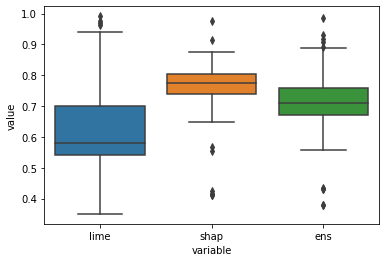

In [75]:
lip_df_fin = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips, 'ens':ens_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df_fin))

### ACC Loss

In [76]:
ens_res_global = pd.DataFrame(ens_res).mean()

ens_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                        importances_orig=ens_res_global, resolution=50,  count_per_step=10, plot=False)

acc_loss_shap = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                        importances_orig=shap_res_global, resolution=50,  count_per_step=10, plot=False)

acc_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                        importances_orig=lime_res_global, resolution=50,  count_per_step=10, plot=False)
[1-auc(np.linspace(0, 1, 50),acc_loss_lime)]

[0.8494364910143162]

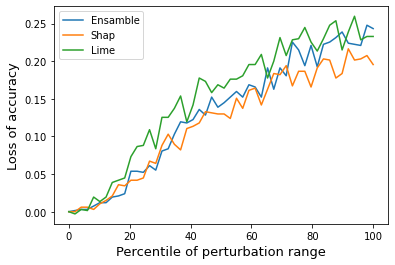

In [77]:
plt.plot(np.linspace(0, 100, 50), ens_loss_lime)
plt.plot(np.linspace(0, 100, 50), acc_loss_shap)
plt.plot(np.linspace(0, 100, 50), acc_loss_lime)
plt.xlabel('Percentile of perturbation range', fontsize=13)
plt.ylabel('Loss of accuracy', fontsize=13)
plt.legend(['Ensamble','Shap','Lime'])

## Consistency of choosen explanation mechanism

In [78]:
src1=pd.DataFrame(minmaxdf(pd.DataFrame(res_shap_con[0]).apply(lambda x: x*weights_df['shap'],axis=0)))

src2=pd.DataFrame(minmaxdf(pd.DataFrame(res_shap_con[1]).apply(lambda x: x*weights_df['shap'],axis=0)))

<AxesSubplot:xlabel='variable', ylabel='value'>

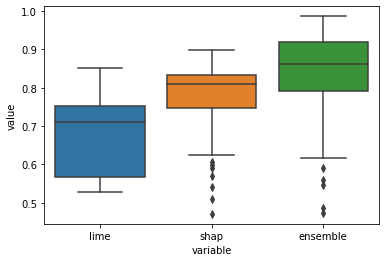

In [79]:
lime_cons = gm.consistency(res_lime_con)
shap_cons = gm.consistency(res_shap_con)
shap_cons_dd =gm.consistency([src1.values,src2.values])
cons_df_ens = pd.DataFrame({'lime':lime_cons, 'shap':shap_cons, 'ensemble':shap_cons_dd})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df_ens))

## Summary Plots
## Obtain explanations by averagingin explanations

In [80]:
def obtain_data_for_weights(cons_alphas = [0.8,0.1,0.1], lip_alphas=[0.1,0.8,0.1], auc_alphas=[0.1,0.1,0.8]):
    nparam = len(cons_alphas)
    fig, axs = plt.subplots(nparam,3,figsize=(12,9))
    for i in range(nparam):
        cons_alpha =cons_alphas[i]
        lip_alpha=lip_alphas[i]
        auc_alpha=auc_alphas[i]
        
        
        weights_df = cons_alpha*(cons_df)+lip_alpha*(lip_df)+auc_alpha/auc_df.values
        weights_df=pd.DataFrame(MinMaxScaler().fit_transform(weights_df), columns=weights_df.columns)
        r1 = weights_df['lime']*pd.DataFrame(lime_res).T
        r2 = weights_df['shap']*pd.DataFrame(shap_res).T
        ensemple_res = (r1+r2)/weights_df.sum(axis=1)
        ens_res = minmaxdf(pd.DataFrame(ensemple_res.T.values))

        ens_confidence = MinMaxScaler([0,1]).fit_transform((weights_df.sum(axis=1)/2).values.reshape(-1,1))
        
        ens_lips = gm.stability(X_test_appended,ens_res,epsilon=0.3)#, confidence=ens_confidence.ravel())
        

        lip_df_fin = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips, 'ens':ens_lips})
        ens_res_global = pd.DataFrame(ens_res).abs().mean()
        
        acc_loss_ens = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                                importances_orig=ens_res_global, resolution=50,  count_per_step=10,
                                               plot=False)
        acc_loss_shap = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                                importances_orig=shap_res_global, resolution=50,  count_per_step=10,
                                               plot=False)
        acc_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                                importances_orig=lime_res_global, resolution=50,  count_per_step=10,
                                               plot=False)

        lime_cons = gm.consistency(res_lime_con)
        shap_cons = gm.consistency(res_shap_con)
        
        src1=pd.DataFrame(minmaxdf(pd.DataFrame(res_shap_con[0]).apply(lambda x: x*weights_df['shap'],axis=0)))
        src2=pd.DataFrame(minmaxdf(pd.DataFrame(res_shap_con[1]).apply(lambda x: x*weights_df['shap'],axis=0)))

        shap_cons_dd =gm.consistency([src1.values,src2.values])#, confidence=[ens_confidence, ens_confidence])
        cons_df_ens = pd.DataFrame({'lime':lime_cons, 'shap':shap_cons, 'ensemble':shap_cons_dd})
    
        sns.boxplot(x="Consistency", y="value", data=pd.melt(cons_df_ens, var_name='Consistency'),ax=axs[i,0])
        sns.boxplot(x="Stability", y="value", data=pd.melt(lip_df_fin,var_name='Stability'),ax=axs[i,1])


        axs[i,2].plot(np.linspace(0, 100, 50), acc_loss_ens)
        axs[i,2].plot(np.linspace(0, 100, 50), acc_loss_shap)
        axs[i,2].plot(np.linspace(0, 100, 50), acc_loss_lime)
        axs[i,2].set(xlabel='Percentile of perturbation range', ylabel='Loss of accuracy')
        axs[i,2].legend(['Ensamble (AUCx='+str("{:.2f}".format(auc(np.linspace(0, 1, 50),acc_loss_ens)))+')',
                         'Shap (AUCx='+str("{:.2f}".format(auc(np.linspace(0, 1, 50),acc_loss_shap)))+')',
                         'Lime (AUCx='+str("{:.2f}".format(auc(np.linspace(0, 1, 50),acc_loss_lime)))+')',])
    return ens_res, lime_res, shap_res, fig

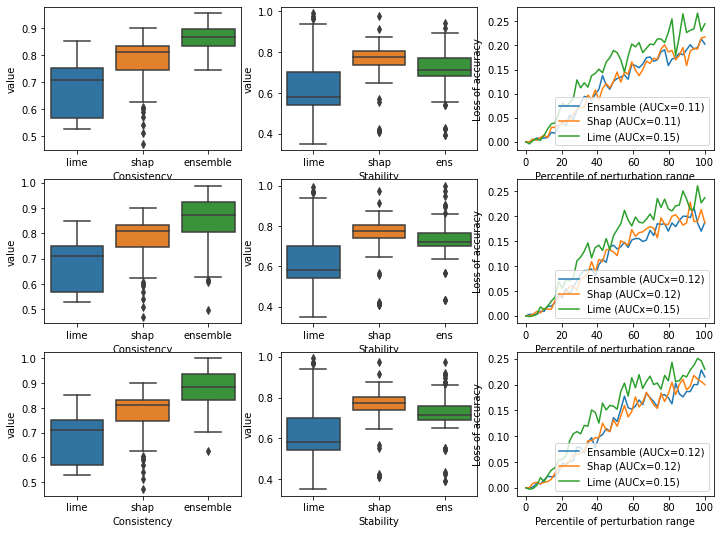

In [81]:
ens_res, lime_res, shap_res, fig=obtain_data_for_weights()

In [82]:
fig.savefig('inxai-results-weight.png')

## Obtain results by selecting best explanation for each sample

In [83]:
def obtain_data_for_weights_select(cons_alphas = [0.8,0.1,0.1], lip_alphas=[0.1,0.8,0.1], auc_alphas=[0.1,0.1,0.8]):
    nparam = len(cons_alphas)
    fig, axs = plt.subplots(nparam,3,figsize=(12,9))
    if len(axs.shape) ==1:
        axs = axs.reshape(1,3)
    for i in range(nparam):
        cons_alpha =cons_alphas[i]
        lip_alpha=lip_alphas[i]
        auc_alpha=auc_alphas[i]
        
        weights_df_orig = cons_alpha*(cons_df)+lip_alpha*(lip_df)+auc_alpha/auc_df.values
        weights_df_orig=pd.DataFrame(MinMaxScaler().fit_transform(weights_df_orig), columns=weights_df_orig.columns)
        weights_df = weights_df_orig.copy()
        
        weights_df.loc[:,:]= MinMaxScaler().fit_transform(weights_df.T).T
        
        r1 = weights_df['lime']*pd.DataFrame(lime_res).T
        r2 = weights_df['shap']*pd.DataFrame(shap_res).T
        ensemple_res = (r1+r2)/weights_df.sum(axis=1)
        ens_res = minmaxdf(pd.DataFrame(ensemple_res.T.values))

        ens_confidence = None#MinMaxScaler([0,1]).fit_transform((weights_df_orig.sum(axis=1)/2).values.reshape(-1,1))
        
        ens_lips = gm.stability(X_test_appended,ens_res,epsilon=0.3)#, confidence=ens_confidence.ravel())
        

        lip_df_fin = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips, 'ens':ens_lips})
        ens_res_global = pd.DataFrame(ens_res).abs().mean()
        
        acc_loss_ens = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                                importances_orig=ens_res_global, resolution=50,  count_per_step=10,
                                               plot=False)
        acc_loss_shap = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                                importances_orig=shap_res_global, resolution=50,  count_per_step=10,
                                               plot=False)
        acc_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, 
                                                importances_orig=lime_res_global, resolution=50,  count_per_step=10,
                                               plot=False)

        lime_cons = gm.consistency(res_lime_con)
        shap_cons = gm.consistency(res_shap_con)
        
        src1=pd.DataFrame(minmaxdf(pd.DataFrame(res_shap_con[0]).apply(lambda x: x*weights_df['shap'],axis=0)))
        src2=pd.DataFrame(minmaxdf(pd.DataFrame(res_shap_con[1]).apply(lambda x: x*weights_df['shap'],axis=0)))
        
        shap_cons_dd =gm.consistency([src1.values,src2.values])
        cons_df_ens = pd.DataFrame({'lime':lime_cons, 'shap':shap_cons, 'ensemble':shap_cons_dd})
    
        sns.boxplot(x="Consistency", y="value", data=pd.melt(cons_df_ens, var_name='Consistency'),ax=axs[i,0])
        sns.boxplot(x="Stability", y="value", data=pd.melt(lip_df_fin,var_name='Stability'),ax=axs[i,1])


        axs[i,2].plot(np.linspace(0, 100, 50), acc_loss_ens)
        axs[i,2].plot(np.linspace(0, 100, 50), acc_loss_shap)
        axs[i,2].plot(np.linspace(0, 100, 50), acc_loss_lime)
        axs[i,2].set(xlabel='Perturbation rate', ylabel='Loss of accuracy')
        axs[i,2].legend(['Ensamble (AUCx='+str("{:.3f}".format(auc(np.linspace(0, 1, 50),acc_loss_ens)))+')',
                         'Shap (AUCx='+str("{:.3f}".format(auc(np.linspace(0, 1, 50),acc_loss_shap)))+')',
                         'Lime (AUCx='+str("{:.3f}".format(auc(np.linspace(0, 1, 50),acc_loss_lime)))+')',])
        
    return ens_res, lime_res, shap_res, fig

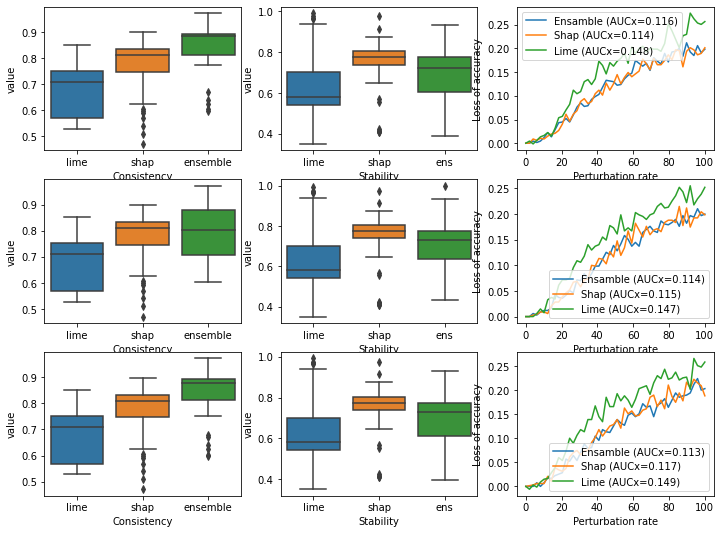

In [84]:
ens_res, lime_res, shap_res, fig=obtain_data_for_weights_select()

In [85]:
fig.savefig('inxai-results.png')

## Confidence plots

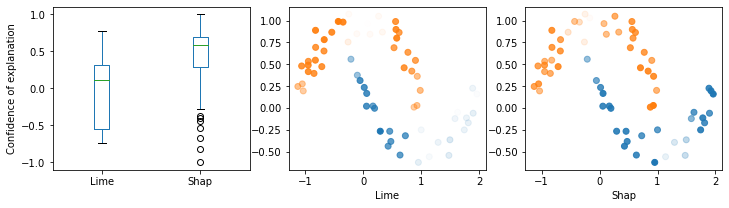

In [86]:
import matplotlib.pylab as plt
from matplotlib import colors

fig, ax = plt.subplots(1, 3, figsize=(12,3))

weights_df = (cons_df+1)+0*(lip_df+1)+0*auc_df.values
confidence = pd.DataFrame(minmaxdf(weights_df), columns=['Lime','Shap'])#pd.DataFrame(MinMaxScaler().fit_transform(weights_df))#.plot(kind='box')
confidence.plot(kind='box', ax=ax[0], ylabel='Confidence of explanation')

X_test_1 = X_test_appended.iloc[y_test_appended==1]
X_test_2 = X_test_appended.iloc[y_test_appended==0]
X_test_1.columns=['Lime','Shap']

c='C0'
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*colors.to_rgb(c),0)), (1, c)])
ax[1].scatter(X_test_1['Lime'], X_test_1['Shap'], c=confidence.iloc[y_test_appended==1,0].values, cmap=cmap)#, ec=None, s=10**2)


c='C1'
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*colors.to_rgb(c),0)), (1, c)])
ax[1].scatter(X_test_2['0'], X_test_2['1'], c=confidence.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(xlabel='Lime')


c='C0'
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*colors.to_rgb(c),0)), (1, c)])
ax[2].scatter(X_test_1['Lime'], X_test_1['Shap'], c=confidence.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c='C1'
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*colors.to_rgb(c),0)), (1, c)])
ax[2].scatter(X_test_2['0'], X_test_2['1'], c=confidence.iloc[y_test_appended==0,1].values, cmap=cmap)#, ec=None, s=10**2)
ax[2].set(xlabel='Shap')
plt.show()

In [87]:
fig.savefig('confidence.png')